<a href="https://colab.research.google.com/github/sinyasco/Machine-Learning-using-Libraries/blob/main/bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

In [88]:
import copy
import tensorflow as tf
import seaborn as sns

In [89]:
from sklearn.linear_model import LinearRegression

# Dataset Source : https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand


In [90]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv",encoding="cp949").drop(["Date", "Holiday", "Seasons"], axis=1)

In [91]:
df.head()

,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [92]:
df.columns = dataset_cols

In [93]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [94]:
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [95]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


/tmp/ipython-input-3099998546.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


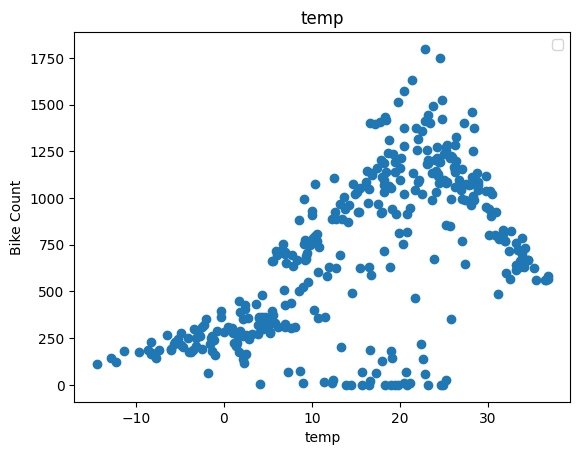

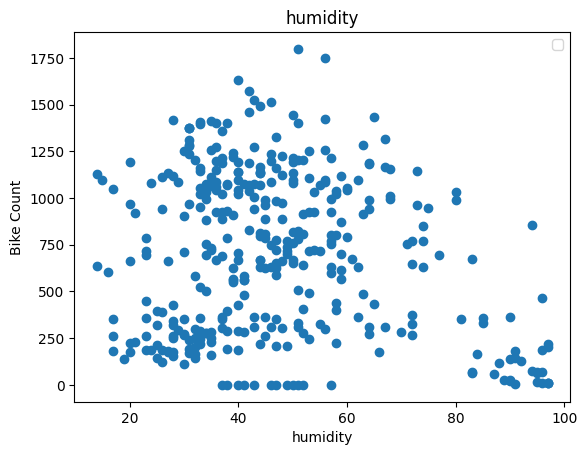

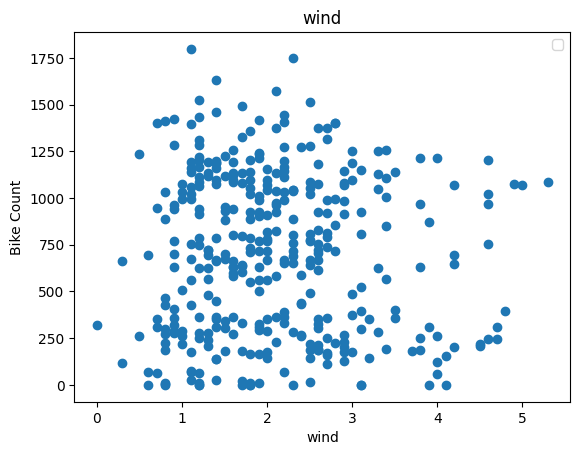

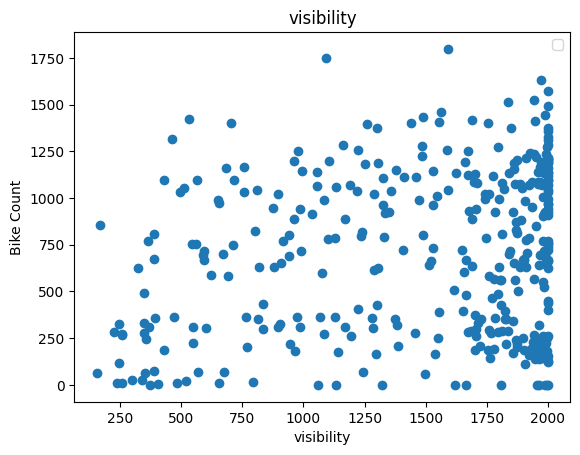

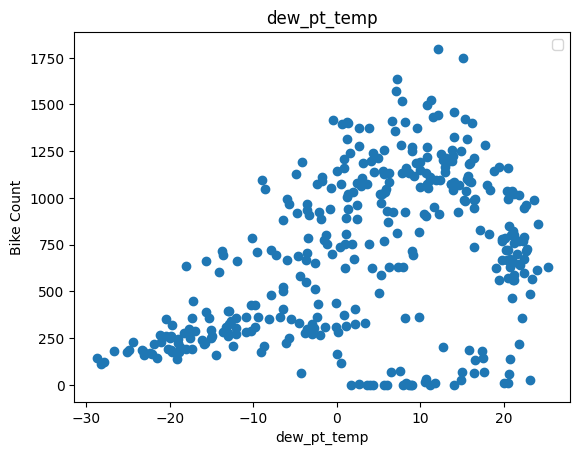

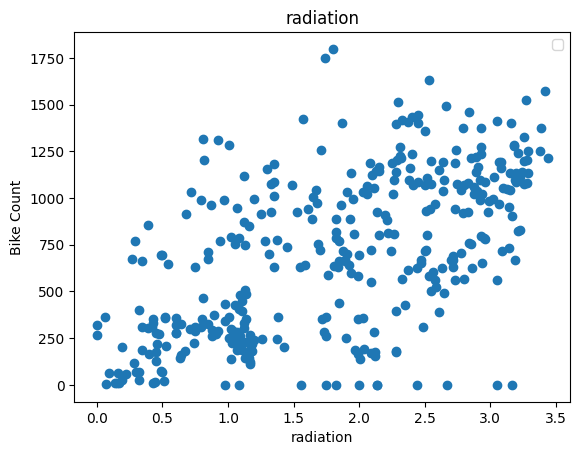

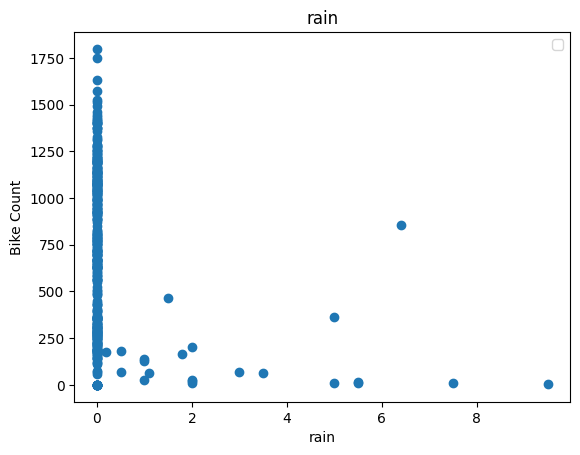

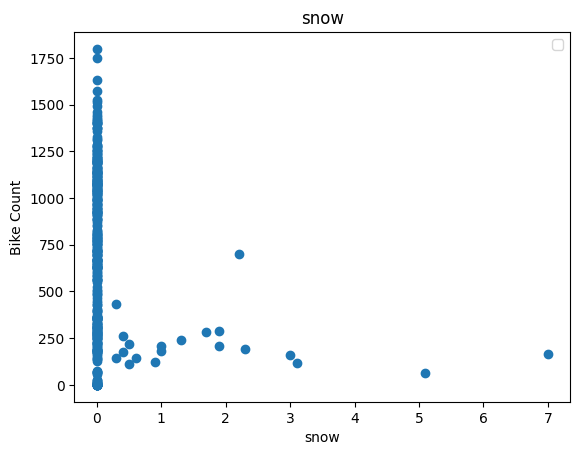

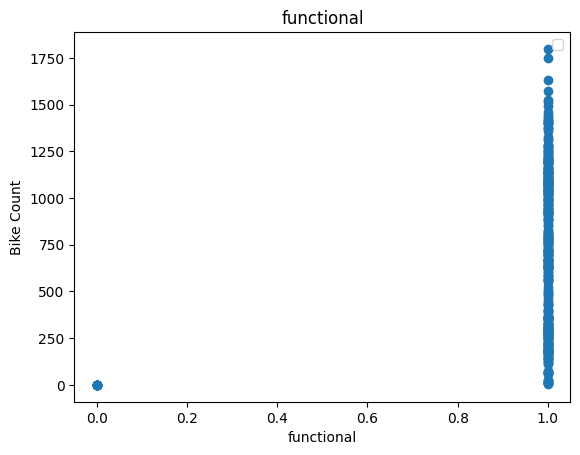

In [96]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count")
  plt.xlabel(label)
  plt.legend()
  plt.show()

In [97]:
df.drop(["wind", "visibility", "functional"], axis=1)

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0
...,...,...,...,...,...,...,...
8652,752,9.1,57,1.0,1.69,0.0,0.0
8676,672,9.3,61,2.1,0.85,0.0,0.0
8700,635,7.9,14,-18.0,1.81,0.0,0.0
8724,661,5.6,27,-11.9,0.34,0.0,0.0


In [98]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [99]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [100]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if not x_labels:
    X= dataframe[[c for c in dataframe.columns if c!= y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data,X,y

# Simple Linear Regression

In [101]:
data, X_train_temp , Y_train_temp = get_xy(train, "bike_count", x_labels = ["temp"])
data, X_val_temp , Y_val_temp = get_xy(val, "bike_count", x_labels = ["temp"])
data, X_test_temp , Y_test_temp = get_xy(test, "bike_count", x_labels = ["temp"])

In [102]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, Y_train_temp)


LinearRegression()

In [103]:
print("Coefficient (weight):", temp_reg.coef_[0])
print("Intercept (bias):", temp_reg.intercept_[0])



Coefficient (weight): [20.23617492]
Intercept (bias): 371.56749117340814


In [104]:
R2Score = temp_reg.score(X_test_temp, Y_test_temp) # its better when R2 converges to 1
print(R2Score)

0.3452926672687008


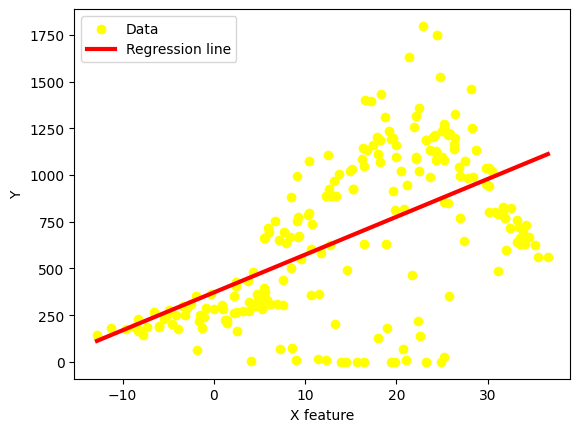

In [105]:
plt.scatter(X_train_temp, Y_train_temp, label="Data", color="yellow")
X_line= np.linspace(X_train_temp.min(), X_train_temp.max(), 100).reshape(-1, 1)
Y_line = temp_reg.predict(X_line)
plt.plot(X_line, Y_line,color="red", label="Regression line",linewidth=3)
plt.xlabel("X feature")
plt.ylabel("Y")
plt.legend()
plt.show()

# Multiple Linear Regression

In [106]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
data, X_train_all , Y_train_all = get_xy(train, "bike_count", x_labels = list(df.columns[1:]))
data, X_val_all , Y_val_all = get_xy(val, "bike_count", x_labels = list(df.columns[1:]))
data, X_test_all , Y_test_all = get_xy(test, "bike_count", x_labels =list(df.columns[1:]))

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [107]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, Y_train_all)


LinearRegression()

In [109]:
all_reg.score(X_test_all,Y_test_all)

0.6363622431469207